In [11]:
import sys
from utils import data_utils
import helper
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math

In [12]:
config = helper.Config("./simulations",defalut_config_file="./default_config_cifar10.ini")

Loading default settings...
[INFO]
num_nodes = 1
gpus_per_node = 1
num_workers = 8
precision = 16-mixed

[DATA]
dataset = CIFAR10
n_views = 4
augmentations = ['RandomResizeCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip']
crop_size = 32
crop_min_scale = 0.08
crop_max_scale = 1.0
hflip_prob = 0.5
blur_kernel_size = 1
blur_prob = 0.5
grayscale_prob = 0.2
jitter_brightness = 0.8
jitter_contrast = 0.8
jitter_saturation = 0.8
jitter_hue = 0.2
jitter_prob = 0.8

[SSL]
backbone = resnet34
backbone_out_dim = 256
use_projection_header = True
proj_out_dim = 2048
optimizer = LARS
lr = 0.0005
lr_scale = linear
momentum = 0.99
weight_decay = 0.0001
lars_eta = 0.1
loss_function = EllipsoidPackingLoss
lw0 = 1.0
lw1 = 1.0
lw2 = 1.0
rs = 3.0
warmup_epochs = 1
n_epochs = 3
batch_size = 32
save_every_n_epochs = 10

[LC]
output_dim = 10
optimizer = SGD
use_batch_norm = True
lr = 0.01
lr_scale = linear
weight_decay = 0.1
momentum = 0.99
loss_function = CrossEntropyLoss
n_epoc

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1406


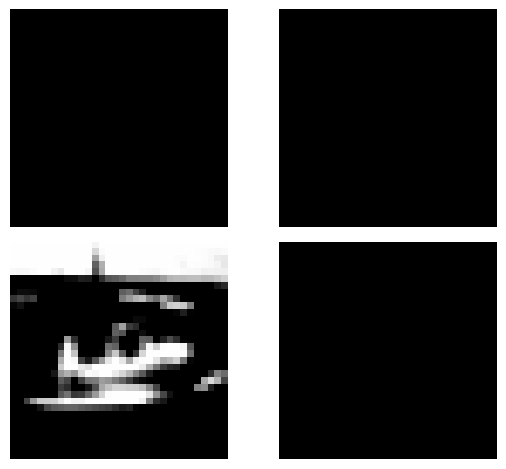

In [13]:
# for multi-gpu trainning, effective batch size = batch_size*num_gpus
ssl_batch_size = config.SSL["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
lc_batch_size = config.LC["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])

ssl_train_loader,lc_train_loader,test_loader,val_loader = data_utils.get_dataloader(config.DATA,ssl_batch_size,lc_batch_size,config.INFO["num_workers"])
imgs,labels = next(iter(ssl_train_loader))
img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)
print(len(ssl_train_loader))

In [14]:
if config.SSL["lr_scale"] == "linear":
    ssl_lr = config.SSL["lr"]*config.SSL["batch_size"]/256.0 # lr ~ 0.1
elif config.SSL["lr_scale"] == "sqrt":
    ssl_lr = config.SSL["lr"]*math.sqrt(config.SSL["batch_size"]) # lr ~ 0.05
torch.cuda.empty_cache()
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  use_projection_header=config.SSL["use_projection_header"],
                                  backbone_out_dim = config.SSL["backbone_out_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = ssl_lr,
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"])

# remove the max pooling layer and change the conv1 layer 
# for CIFAR10 dataset since the image is small(32*32)
if config.DATA["dataset"] == "CIFAR10":
    ssl_model.backbone.remove_maxpool()
    ssl_model.backbone.replace_conv1()

In [ ]:
ssl_dir = os.path.join(config.loc,"ssl")
if not os.path.isdir(ssl_dir):
    os.makedirs(ssl_dir)
ssl_model = lightning_models.train_clap(model=ssl_model, 
                                        train_loader = ssl_train_loader,
                                        max_epochs=config.SSL["n_epochs"],
                                        every_n_epochs = config.SSL["save_every_n_epochs"],
                                        precision = config.INFO["precision"],
                                        checkpoint_path=ssl_dir)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 137
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | backbone | BackboneNet | 21.9 M | train
-------------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.739    Total estimated model params size (MB)
120       Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

In [10]:
lc_dir = os.path.join(config.loc,"lc")
if not os.path.isdir(lc_dir):
    os.makedirs(lc_dir)
ssl_model.backbone.remove_projection_header()
if config.LC["lr_scale"] == "linear":
    lc_lr = config.LC["lr"]*config.LC["batch_size"]/256.0 # lr ~ 0.1
elif config.LC["lr_scale"] == "sqrt":
    lc_lr = config.LC["lr"]*math.sqrt(config.LC["batch_size"]) # lr ~ 0.05
lc_model = lightning_models.LinearClassification(
                 in_dim = config.SSL["backbone_out_dim"],
                 out_dim = config.LC["output_dim"],
                 use_batch_norm = config.LC["use_batch_norm"],
                 optim_name = config.LC["optimizer"],
                 lr = lc_lr, 
                 momentum = config.LC["momentum"],
                 weight_decay = config.LC["weight_decay"],
                 n_epochs = config.LC["n_epochs"])
lc_model.set_backbone(ssl_model.backbone)
lc_model = lightning_models.train_lc(ssl_model = ssl_model, 
            ssl_ckpt_path = ssl_dir,
            linear_model = lc_model,
            train_loader = lc_train_loader,
            val_loader = val_loader,
            test_loader = test_loader,
            max_epochs = config.LC["n_epochs"],
            every_n_epochs = config.LC["save_every_n_epochs"],
            precision = config.INFO["precision"],
            checkpoint_path = lc_dir,
            mode = config.LC["training_mode"])

KeyError: 'save_every_n_epochs'

In [ ]:
lc_model.load_from_customized_checkpoint(os.path.join("./simulations/lc","last.ckpt"))